#DEEP LEARNING
##LAB 7

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import numpy as np
from scipy.stats import entropy
from scipy.linalg import sqrtm


In [ ]:
torch.manual_seed(42)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Define hyperparameters
batch_size = 128
latent_dim = 100
num_epochs = 10
lr = 0.0002
beta1 = 0.5
beta2 = 0.999


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [ ]:
# Load dataset
train_dataset = SVHN(root='./data', split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 182040794/182040794 [00:16<00:00, 10792342.59it/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Initialize
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define optimizers and loss function
optimizer_gen = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
criterion = nn.BCELoss()
criterion_ls = nn.MSELoss()

disc_losses = []
gen_losses = []


In [ ]:
# Training loop
for epoch in range(num_epochs):
    epoch_disc_loss = 0.0
    epoch_gen_loss = 0.0

    generator.train()
    discriminator.train()

    for i, data in enumerate(train_loader):
        discriminator.zero_grad()

        real_images, _ = data
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(z)

        real_outputs = discriminator(real_images)
        fake_outputs = discriminator(fake_images.detach())

        real_targets = torch.ones_like(real_outputs)
        fake_targets = torch.zeros_like(fake_outputs)

        real_loss = criterion(real_outputs, real_targets)
        fake_loss = criterion(fake_outputs, fake_targets)
        disc_loss = real_loss + fake_loss

        disc_loss.backward()
        optimizer_disc.step()

        generator.zero_grad()

        fake_images = generator(z)
        outputs = discriminator(fake_images)

        gen_targets = torch.ones_like(outputs)

        gen_loss = criterion(outputs, gen_targets)

        gen_loss.backward()
        optimizer_gen.step()

        epoch_disc_loss += disc_loss.item()
        epoch_gen_loss += gen_loss.item()

    avg_epoch_disc_loss = epoch_disc_loss / len(train_loader)
    avg_epoch_gen_loss = epoch_gen_loss / len(train_loader)

    disc_losses.append(avg_epoch_disc_loss)
    gen_losses.append(avg_epoch_gen_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {avg_epoch_disc_loss:.4f}, Generator Loss: {avg_epoch_gen_loss:.4f}')


Epoch [1/10], Discriminator Loss: 0.3748, Generator Loss: 4.2122
Epoch [2/10], Discriminator Loss: 0.6440, Generator Loss: 2.8134
Epoch [3/10], Discriminator Loss: 0.5076, Generator Loss: 3.2159
Epoch [4/10], Discriminator Loss: 0.3704, Generator Loss: 3.8843
Epoch [5/10], Discriminator Loss: 0.3348, Generator Loss: 4.3682
Epoch [6/10], Discriminator Loss: 0.2706, Generator Loss: 4.7668
Epoch [7/10], Discriminator Loss: 0.2074, Generator Loss: 5.2058
Epoch [8/10], Discriminator Loss: 0.2098, Generator Loss: 5.2391
Epoch [9/10], Discriminator Loss: 0.3211, Generator Loss: 4.8137
Epoch [10/10], Discriminator Loss: 0.1920, Generator Loss: 4.9644


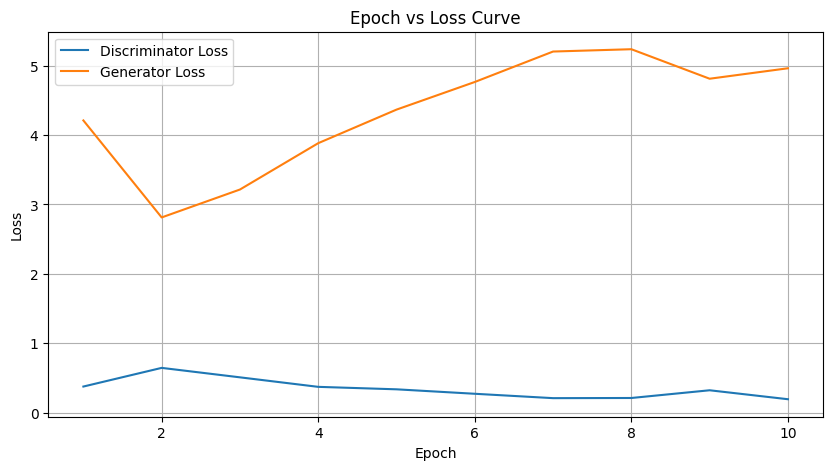

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), disc_losses, label='Discriminator Loss')
plt.plot(range(1, num_epochs+1), gen_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
with torch.no_grad():
    z = torch.randn(10, latent_dim, 1, 1, device=device)
    fake_images = generator(z)
    save_image(fake_images, 'generated_images.png', nrow=10, normalize=True)


In [ ]:
def sqrtm(matrix):
    eigenvalues, eigenvectors = torch.linalg.eigh(matrix)
    sqrt_eigenvalues = torch.sqrt(torch.abs(eigenvalues))
    sqrt_matrix = eigenvectors @ torch.diag(sqrt_eigenvalues) @ eigenvectors.t()

    return sqrt_matrix

def calculate_fid_score(real_images, generated_images):
    mu_real = torch.mean(real_images, dim=0)
    mu_gen = torch.mean(generated_images, dim=0)

    real_images_flat = real_images.view(real_images.size(0), -1)
    generated_images_flat = generated_images.view(generated_images.size(0), -1)

    diff_real = real_images_flat - mu_real.view(1, -1)
    cov_real = torch.matmul(diff_real.t(), diff_real) / (len(real_images_flat) - 1)

    diff_gen = generated_images_flat - mu_gen.view(1, -1)
    cov_gen = torch.matmul(diff_gen.t(), diff_gen) / (len(generated_images_flat) - 1)

    cov_sqrt = sqrtm(torch.matmul(cov_real, cov_gen))
    fid_score = torch.norm(mu_real - mu_gen) + torch.trace(cov_real + cov_gen - 2 * cov_sqrt)
    return fid_score.item()

real_images = torch.stack([train_dataset[i][0] for i in range(100)], dim=0).to(device)
generated_images = torch.stack([generator(torch.randn(1, latent_dim, 1, 1, device=device)).squeeze() for _ in range(100)], dim=0)
fid_score = calculate_fid_score(real_images, generated_images)
print(f'FID Score: {fid_score:.4f}')


FID Score: -4639.2212


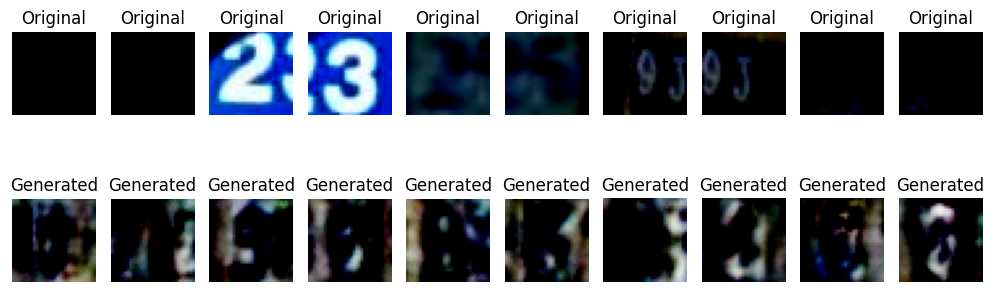

In [ ]:
import matplotlib.pyplot as plt

# Function to plot original and generated images
def plot_images(original_images, generated_images):
    num_images = len(original_images)
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(10, 4))

    for i in range(num_images):
        # Move tensors from GPU to CPU and convert to numpy array
        original_img_np = original_images[i].cpu().detach().permute(1, 2, 0).numpy()
        generated_img_np = generated_images[i].cpu().detach().permute(1, 2, 0).numpy()

        axes[0, i].imshow(original_img_np)  # Plot original image
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(generated_img_np)  # Plot generated image
        axes[1, i].axis('off')
        axes[1, i].set_title('Generated')

    plt.tight_layout()
    plt.show()

# Plot original and generated images
plot_images(real_images[:10], generated_images[:10])
